# Getting reservoirs from the GWW project

either by hand:

In [16]:
import json
import os
from pathlib import Path
import subprocess

output: subprocess.CompletedProcess = subprocess.run(["mamba", "list", "^proj", "--json"], capture_output=True)
proj_dist_name: str = json.loads(output.stdout)[0]["dist_name"]
os.environ["PROJ_LIB"]=f"/opt/conda/pkgs/proj-{proj_dist_name}"

In [17]:
import fiona
from google.cloud.storage import Blob, Bucket, Client

In [18]:
gcp_project: str = "global-water-watch"
gcp_bucket: str = "global-water-watch"

os.environ["GCLOUD_PROJECT"] = "global-water-watch"

out_dir: Path = Path.cwd() / "output"

In [19]:
client: Client = Client()
bucket: Bucket = Bucket(client, name=gcp_bucket, user_project=gcp_project)

In [20]:
reservoir_dir: Path = out_dir / "reservoirs"
blob: Blob = client.list_blobs(bucket, prefix="shp/reservoirs-v1.0")
for b in blob:
    b.download_to_filename(reservoir_dir / b.name.split("/")[-1])

In [98]:
shapes = fiona.open(reservoir_dir / "reservoirs-v1.0.shp")

In [115]:
next(iter(shapes))

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('fid', 1.0),
              ('source_nam', 'osm_way'),
              ('source_id', 338083400),
              ('name', None),
              ('name_en', None),
              ('grand_id', None)]),
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[(-84.09436956043794, 30.862290117978194),
     (-84.09470847929936, 30.862160730823835),
     (-84.09493144271363, 30.86224107162828),
     (-84.09492701085038, 30.862713663736457),
     (-84.09476641602296, 30.86277164651669),
     (-84.09475303981634, 30.86233019394484),
     (-84.09436956043794, 30.862290117978194)]],
   [[(-84.09436956043794, 30.862290117978194),
     (-84.09436956043794, 30.862606652340492),
     (-84.09474860793998, 30.86280287289627),
     (-84.09431605524152, 30.862856412041136),
     (-84.09419123645864, 30.862695864357537),
     (-84.09412435475791, 30.862521980368165),
     (-84.09436956043794, 30.862290117978194)]]]}}

In [102]:
from functools import reduce

def process_shapes(collection: dict, shape: dict):
    fid: int = int(shape["properties"]["fid"])
    s_type: str = shape["geometry"]["type"]
    coords: List = shape["geometry"]["coordinates"]
    if s_type == "MultiPolygon":
        collection.update({fid: MultiPolygon([Polygon(c[0]) for c in coords])})
    elif s_type == "Polygon":
        collection.update({fid: Polygon(coords[0])})
    return collection

p_shapes = reduce(process_shapes, iter(shapes), {})

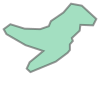

In [114]:
p_shapes[60000]

# With class:

In [1]:
from utils import Reservoir
from pathlib import Path

reservoir_dir: Path = Path.cwd() / "output" / "reservoirs"
reservoirs = Reservoir.from_gcp(reservoir_dir)

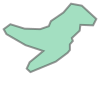

In [2]:
next(filter(lambda r: r.fid() == 60000, reservoirs)).geometry

# Filter all reservoirs within bbox

For the workflow in mind, we want to filter all reservoirs within the bounding box of the area selected.
Getting the reservoir in question: https://code.earthengine.google.com/bf5e67d0efc01b434ddc23c0db74e642

In [51]:
import geojson
from shapely.geometry import MultiPolygon, Polygon

shapely_polygon_chzech = Polygon([[12.09,51.06],[12.09, 48.55], [18.87,48.55], [18.87, 51.06], [12.09,51.06]])
geojson_str = "{\"type\":\"Polygon\",\"coordinates\":[[[16.258372886421807,49.561646293673824],[16.314909857006697,49.561646293673824],[16.314909857006697,49.58980547068479],[16.258372886421807,49.58980547068479],[16.258372886421807,49.561646293673824]]],\"geodesic\":false}"
bbox: geojson.Polygon = geojson.loads(geojson_str)
shapely_polygon = Polygon(bbox.coordinates[0]).buffer(0.001)  # need to slightly buffer to contain reservoir

selected = list(filter(lambda r: shapely_polygon.covers(r.geometry), reservoirs))

In [52]:
len(selected)

1

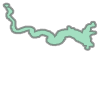

In [54]:
selected[0].geometry